In [1]:
!pip install backtesting
from backtesting.test import EURUSD, SMA, GOOG

/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [6]:
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pandas_ta as ta
import yfinance as yahooFinance
import datetime
!pip install pandas_ta
import pandas_ta as ta

In [4]:
GetFacebookInformation = yahooFinance.Ticker("META")
startDate = datetime.datetime(2012, 5, 31)

# endDate , as per our convenience we can modify
endDate = datetime.datetime(2024, 4, 30)
data = GetFacebookInformation.history(start=startDate,
                                     end=endDate)

In [5]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-31 00:00:00-04:00,28.519740,29.638554,26.801564,29.568628,111639200,0.0,0.0
2012-06-01 00:00:00-04:00,28.859378,29.119103,27.360968,27.690619,41855500,0.0,0.0
2012-06-04 00:00:00-04:00,27.171172,27.620694,26.411977,26.871489,35230300,0.0,0.0
2012-06-05 00:00:00-04:00,26.671701,27.730577,25.722707,25.842581,42473400,0.0,0.0
2012-06-06 00:00:00-04:00,26.042368,27.141203,25.492952,26.781584,61489200,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,491.250000,498.760010,488.970001,496.100006,15079200,0.0,0.0
2024-04-24 00:00:00-04:00,508.059998,510.000000,484.579987,493.500000,37772700,0.0,0.0
2024-04-25 00:00:00-04:00,421.399994,445.769989,414.500000,441.380005,82890700,0.0,0.0


In [9]:
def trendline_breakout_dataset(
        ohlcv: pd.DataFrame, lookback: int,
        hold_period: int = 12, tp_mult: float = 3.0, sl_mult: float = 3.0,
        atr_lookback: int = 168
):
    assert (atr_lookback >= lookback)

    close = np.log(ohlcv['Close'].to_numpy())

    # ATR for normalizing, setting stop loss take profit
    atr = ta.atr(np.log(ohlcv['High']), np.log(ohlcv['Low']), np.log(ohlcv['Close']), atr_lookback)
    atr_arr = atr.to_numpy()

    # Normalized volume
    vol_arr = (ohlcv['Volume'] / ohlcv['Volume'].rolling(atr_lookback).median()).to_numpy()
    adx = ta.adx(ohlcv['High'], ohlcv['Low'], ohlcv['Close'], lookback)
    adx_arr = adx['ADX_' + str(lookback)].to_numpy()

    trades = pd.DataFrame()
    trade_i = 0

    in_trade = False
    tp_price = None
    sl_price = None
    hp_i = None
    for i in range(atr_lookback, len(ohlcv)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line
        r_val = r_coefs[1] + lookback * r_coefs[0]

        # Entry
        if not in_trade and close[i] > r_val:
            tp_price = close[i] + atr_arr[i] * tp_mult
            sl_price = close[i] - atr_arr[i] * sl_mult
            hp_i = i + hold_period
            in_trade = True

            trades.loc[trade_i, 'entry_i'] = i
            trades.loc[trade_i, 'entry_p'] = close[i]
            trades.loc[trade_i, 'atr'] = atr_arr[i]
            trades.loc[trade_i, 'sl'] = sl_price
            trades.loc[trade_i, 'tp'] = tp_price
            trades.loc[trade_i, 'hp_i'] = i + hold_period

            trades.loc[trade_i, 'slope'] = r_coefs[0]
            trades.loc[trade_i, 'intercept'] = r_coefs[1]

            # Trendline features
            # Resist slope
            trades.loc[trade_i, 'resist_s'] = r_coefs[0] / atr_arr[i]

            # Resist erorr
            line_vals = (r_coefs[1] + np.arange(lookback) * r_coefs[0])
            err = np.sum(line_vals - window) / lookback
            err /= atr_arr[i]
            trades.loc[trade_i, 'tl_err'] = err

            # Max distance from resist
            diff = line_vals - window
            trades.loc[trade_i, 'max_dist'] = diff.max() / atr_arr[i]

            # Volume on breakout
            trades.loc[trade_i, 'vol'] = vol_arr[i]

            # ADX
            trades.loc[trade_i, 'adx'] = adx_arr[i]

        if in_trade:
            if close[i] >= tp_price or close[i] <= sl_price or i >= hp_i:
                trades.loc[trade_i, 'exit_i'] = i
                trades.loc[trade_i, 'exit_p'] = close[i]

                in_trade = False
                trade_i += 1

    trades['return'] = trades['exit_p'] - trades['entry_p']

    # Features
    data_x = trades[['resist_s', 'tl_err', 'vol', 'max_dist', 'adx']]
    # Label
    data_y = pd.Series(0, index=trades.index)
    data_y.loc[trades['return'] > 0] = 1

    return trades, data_x, data_y

In [10]:
def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared)
    # coefs[0] = slope,  coefs[1] = intercept
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()

    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

NameError: name 'np' is not defined

In [11]:

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()

    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)



NameError: name 'np' is not defined

In [12]:

def trendline_breakout(close: np.array, lookback: int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in range(lookback, len(close)):
        # NOTE window does NOT include the current candle
        window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0]
        r_val = r_coefs[1] + lookback * r_coefs[0]

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig


NameError: name 'np' is not defined

In [13]:

def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices,
    # return negative val if invalid

    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept

    diffs = line_vals - y

    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line
    err = (diffs ** 2.0).sum()
    return err



NameError: name 'np' is not defined

In [14]:

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y)

    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step  # current step

    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert (best_err >= 0.0)  # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases.
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;

            # If increasing by a small amount fails,
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0:  # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:
            # slope failed/didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative

    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])


NameError: name 'np' is not defined

In [15]:

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length

    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio))):
                trendcat[line] = -1  # -1 downtrend
                break
            elif ((valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 1  # uptrend
                break
            else:
                trendcat[line] = 0  # no clear trend

    return trendcat



In [16]:
#mytarget(16, data)


In [17]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(24).shift(-24)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

In [25]:
pipdiff = 500 * 1e-5  # for TP
SLTPRatio = 2  # pipdiff/Ratio gives SL

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [26]:
from scipy.stats import linregress


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)


# Price-derived features
data['MA20'] = data.ta.sma(length=20)
data['MA50'] = data.ta.sma(length=50)
data['MA200'] = data.ta.sma(length=200)
data['X_RSI'] = data.ta.rsi()
data['X_EMA']=ta.sma(data.Close, length=200)#sma ema


backrolling = 6
data['X_slopeMA20'] = data['MA20'].rolling(window=backrolling).apply(get_slope, raw=True)
data['X_slopeMA50'] = data['MA50'].rolling(window=backrolling).apply(get_slope, raw=True)
data['X_slopeMA200'] = data['MA200'].rolling(window=backrolling).apply(get_slope, raw=True)


# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

In [27]:
data = data.dropna().astype(float)

In [28]:
def addemasignal(df, backcandles):
    emasignal = [0]*len(df)
    for row in range(backcandles, len(df)):
        upt = 1
        dnt = 1
        for i in range(row-backcandles, row+1):
            if df.High[i]>=df.X_EMA[i]:
                dnt=0
            if df.Low[i]<=df.X_EMA[i]:
                upt=0
        if upt==1 and dnt==1:
            #print("!!!!! check trend loop !!!!")
            emasignal[row]=3
        elif upt==1:
            emasignal[row]=2
        elif dnt==1:
            emasignal[row]=1
    df['EMASignal'] = emasignal

addemasignal(data, 6)

In [29]:
X, y = get_clean_Xy(data)
X
y

array([ 1.,  1.,  1., ..., -1., -1., -1.])

Classification accuracy:  0.632295719844358


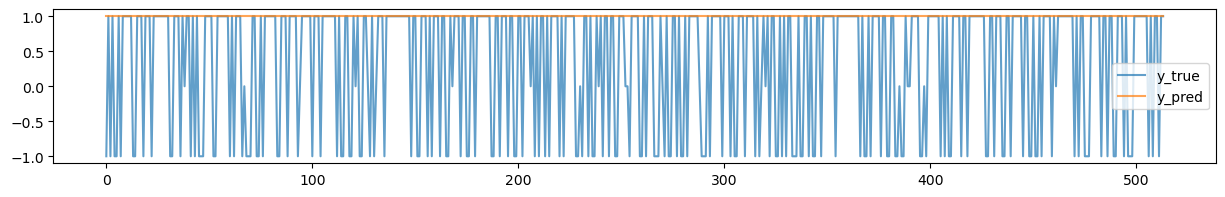

In [32]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


df = data
X, y = get_clean_Xy(df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=0)



clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X, y)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [33]:
 %%time

from backtesting import Backtest, Strategy

N_TRAIN = 1000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)

        # Additionally, set aggressive stop-loss on trades that have been open
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('1 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, cash=10000, commission=.0002, margin=.05)
bt.run()

CPU times: user 640 ms, sys: 6.75 ms, total: 647 ms
Wall time: 684 ms


Start                     2014-01-08 00:00...
End                       2024-04-29 00:00...
Duration                   3763 days 23:00:00
Exposure Time [%]                   10.948342
Equity Final [$]                   397.830407
Equity Peak [$]                   10102.04682
Return [%]                         -96.021696
Buy & Hold Return [%]              643.738655
Return (Ann.) [%]                  -26.892069
Volatility (Ann.) [%]                9.305689
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -96.061883
Avg. Drawdown [%]                  -96.061883
Max. Drawdown Duration     2314 days 00:00:00
Avg. Drawdown Duration     2314 days 00:00:00
# Trades                                  284
Win Rate [%]                         5.985915
Best Trade [%]                       0.618905
Worst Trade [%]                     -3.544599
Avg. Trade [%]                    

In [34]:
bt.plot()

/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1642', ...)